In [2]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pymesh
import meshio
%matplotlib inline
plt.rcParams["figure.figsize"] = 12.8, 9.6

In [3]:
def plot_mesh(mesh):
    ax = plt.axes(projection='3d')
    x = mesh.vertices[:,0]
    y = mesh.vertices[:,1]
    z = mesh.vertices[:,2]
    triangles = mesh.faces[:]

    ax.plot_trisurf(x,z,triangles,y, shade=True, color='white')
    
    ax.set_ylim(-2,2)
    ax.set_xlim(-2, 2)
    ax.set_zlim(0,4)
    
    plt.show()
    
def resize_mesh(mesh, tol):
    """Takes mesh & resizes triangles to tol size"""
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100);
    mesh, _info = pymesh.split_long_edges(mesh, tol)
    mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6);
    mesh, _info = pymesh.collapse_short_edges(mesh, tol, preserve_feature=True)
    return mesh

def write_mesh(mesh, filename):
    points = mesh.vertices
    cells = {"triangle": mesh.faces}
    meshio.write_points_cells(
        filename,
        points,
        cells,
        # Optionally provide extra data on points, cells, etc.
        point_data={
            "is_boundary":mesh.get_attribute("is_boundary")
        },
        # cell_data=cell_data,
        # field_data=field_data
        )


In [4]:
CELL_SIZE=1e-1

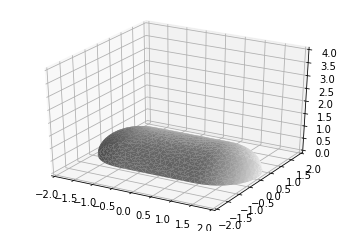

In [5]:
mesh = pymesh.load_mesh("meshes/sausage_shape.obj")

mesh = resize_mesh(mesh, CELL_SIZE)

mesh.add_attribute("is_boundary")
val = np.ones(mesh.num_vertices)
mesh.set_attribute("is_boundary", val)

pymesh.save_mesh("meshes/regularised_cell.ply", mesh)
write_mesh(mesh, "meshes/regularised_cell.vtk")

plot_mesh(mesh)

In [27]:
tetmesh = pymesh.tetrahedralize(mesh, CELL_SIZE*2)
pymesh.save_mesh("meshes/regularised_cell_tetra.ply", tetmesh)

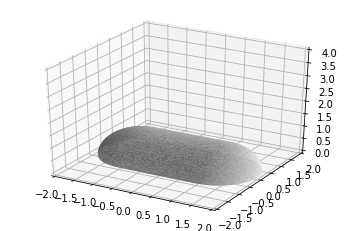

In [25]:
boundary_mesh = pymesh.compute_outer_hull(tetmesh)
plot_mesh(boundary_mesh)

In [28]:
is_boundary = np.zeros(tetmesh.num_vertices)
source_faces = boundary_mesh.get_attribute("face_sources").astype(int)
for i_face in source_faces:
    face = tetmesh.faces[i_face]
    is_boundary[face] = True

tetmesh.add_attribute("is_boundary")
tetmesh.set_attribute("is_boundary", is_boundary)

write_mesh(tetmesh, "meshes/regularised_cell_tetra.vtk")